# Analyse und Visualisierung der Daten

# Analysekriterium: Korrelation

Die Bibliothek numpy besitzt die Funktion corrcoef, welche bei Eingabe zwei gleich großer Listen die Korrelation beider Listen bestimmt. Die Funktion nimmt dabei Werte von -1 (negative Korrelation) und 1 (positive Korrelation) an. 0 bedeutet, dass die Listen nicht miteinander korrelieren.

In [1]:
# Import von numpy zur Berechnung der Korrelation zwischen zwei Variablen
import numpy as np

In [2]:
a = [0, 2, 4, 6, 9]
b = [1, 2, 3, 4, 5]

In [3]:
np.corrcoef(a, b)[0,1]

0.9958932064677037

In diesem einfachen Beispiel sieht man, dass die beiden Listen a und b, welche sich beide stetig, aber um einen anderen Faktor vergrößern, stark miteinander korrelieren.

In [4]:
import random

random.seed(10)
c = random.sample(range(0, 20), 10)
d = random.sample(range(0, 20), 10)

In [5]:
np.corrcoef(c, d)[0,1]

-0.0009221679061967371

Vergleicht man stattdessen zufällige Listen, dann gehen die Korrelationswerte gegen 0, also ist keine Korrelation anzunehmen.

# Analyse 1: Korrelation der Fußgänger und des Wetters

# Analyse 2: Korrelation der Fußgänger und der Corona-Daten

## Vorbereitung der Daten

### Regionen

In dem Dictionary regions werden die 6 betrachteten Regionen als Schlüssel definiert und ihnen jeweils die betrachtete Straße der Fußgängerdaten, sowie der zugehörigen Landkreis und die Einwohnerzahl des Landkreises (manuell aus dem destatis-Daten abgelesen) zugewiesen.

In [6]:
regions = {
    "München":["Kaufingerstraße, München","SK München",1488202],
    "Hamburg":["Große Bleichen, Hamburg","SK Hamburg",1852478],
    "Köln":["Ehrenstraße (Mitte), Köln","SK Köln",1083498],
    "Dresden":["Prager Straße (Nord), Dresden","SK Dresden",556227],
    "Mannheim":["Planken (Ost), Mannheim","SK Mannheim",309721],
    "Frankfurt":["Zeil (Mitte), Frankfurt a.M.","SK Frankfurt am Main",764104]
}

### Zugriff auf MongoDB

Im nächsten Schritt wird auf den die beiden MongoDB-Tabellen pedestrians und incidences zugegriffen, welche aus dem Import- und ETL-Schritt mittels Kafka hervorgehen.

In [7]:
from pymongo import MongoClient
import datetime as dt

client = MongoClient('mongodb://localhost:27017/')

pedestrians = client.pedcov.pedestrians
incidences = client.pedcov.incidences

### Dictionary mit Fußgängern und Fallzahlen bzw. Inzidenzen pro Tag

Am wichtigsten für die weitere Analyse ist es, sowohl die Anzahl an Fußgängern als auch die Summe an Coronafällen bzw. die hervorgehende Inzidenz nach Datum sortiert vorliegen zu haben. In diesem Schritt muss auch jeweils nach der betrachteten Region gefiltert werden, sofern nicht alle Regionen betrachtet werden. 

Diese Schritte sind auf die folgenden Funktionen aufgeteilt:
1. **ped_case_dic(region):** \
    Dictionary mit Fußgängern und Fallzahlen wird mittels Hilfsfunktionen aus Schritt 2 und 3 erstellt.
2. **add_peds_to_dic(dic, street)**: \
    Dem leeren Dictionary (nur mit Datum jeweils als Schlüssel) wird pro Tag die zugehörige Fußgängerzahl zugewiesen.
3. **add_cases_to_dic(dic, landkreis)**: \
    Dem Dictionary mit Fußgängerzahlen werden zusätzlich pro Tag die zugehörige Anzahl an Coronafällen zugewiesen.
4. **to_incidences(dic, region)**: \
    Das Dictionary wird so umgewandelt, dass die Fallzahlen durch Inzidenzen ersetzt werden.

(2. und 3. müssen vor 1. ausgeführt werden, da dies Hilfsfunktion für 1. sind)

#### 2. Fußgänger zu Dictionary hinzufügen

In [8]:
def add_peds_to_dic(dic, street):
    pipeline = []
    
    if(street):
        pipeline = [{"$match": {"location": street}}]
    
    else:
        pipeline = [{"$group": {"_id": "$time of measurement","pedestrians count": {"$sum": "$pedestrians count"}}}]
    
    for row in pedestrians.aggregate(pipeline):
        time = row['_id']
        if(street):
            time = row['time of measurement']
        date = dt.datetime.strptime(time, '%Y-%m-%d').date()
        dic[date][0] = int(row['pedestrians count'])
        
    return dic

#### 3. Fallzahlen zu Dictionary hinzufügen

In [9]:
def add_cases_to_dic(dic, landkreis):
    and_case = [{"$or": [{"Neuer Fall": "0"}, {"Neuer Fall": "1"}]}]
    
    if(landkreis):
        and_case.append({"Landkreis": landkreis})
    
    pipeline = [{
                "$match": 
                    {"$and":and_case}
            },
            {
                "$group": {"_id": "$Meldedatum","Fälle": {"$sum": "$Anzahl Fall"}}
            }]
    
    for row in incidences.aggregate(pipeline):
            date = dt.datetime.strptime(row['_id'], '%Y-%m-%d').date()
            dic[date][1] = int(row['Fälle'])

    return dic

#### 1. Dictionary mit Fußgängerzahlen und Fallzahlen erstellen

In [10]:
# creates dic:  {date: [pedstrians, covid cases]}
def ped_case_dic(region):
    dic = {}
    
    # initialize dictionary to have all dates in the year
    date = dt.date(2020,1,1)
    end_date = dt.date(2020,12,31)
    while date <= end_date:
        dic[date] = [None, 0]
        date += dt.timedelta(days = 1)
    
    # find out location for aggregation
    # if aggregation over alll locations, all location values are None
    street = None
    lk = None
    if(region):
        street, lk, _ = regions[region]

    # pedestrians (only München)
    dic = add_peds_to_dic(dic, street)

    # incidences (only München, NeuerFall in (0, 1)) -> aggregiert nach Meldedatum (Summe Fälle)
    dic = add_cases_to_dic(dic, lk)
    
    return dic

#### 4. Umwandlung der Fälle in Inzidenzen

Die Funktion to_incidences berechnet anhand eines Dictionaries mit den einzelnen Tagen des betrachteten Zeitraumes als Schlüsseln und den dazu gehörigen Coronafällen an diesem Tag in dem betrachteten Landkreis die jeweilige 7-Tage-Inzidenz an dem jeweiligen Tag, indem die Fälle der letzten 7 Tage plus des jeweiligen Tages summiert werden und dann folgende Formel angewandt wird:

Inzidenz = (Anzahl_Fälle * 100.000) / Einwohnerzahl

Dazu nimmt die Funktion ein Dictionary der Form d = {datum: fälle} 

und gibt ein passendes dictionary res = {datum: inzidenzen} zurück.

In [11]:
def to_incidences(dic, region):
    res = {}
    
    # calculate population number
    einwohner = 0
    if(region):
        einwohner = regions[region][2]
    else:
        einwohner = sum([e for street,lk,e in regions.values()])
        
    # add the first 7 days a 0
    cur_date = dt.date(2020,1,1)
    for i in range(7):
        res[cur_date] = [dic[cur_date][0],0]
        cur_date += dt.timedelta(days = 1)
    
    for date in dic:
        if(date >= dt.date(2020,12,25)):
            break
            
        cases = 0
        cur_date = date
        cases += dic[cur_date][1]
        for delta in range(7):
            cur_date += dt.timedelta(days = 1)
            cases += dic[cur_date][1]
        
        incidence = (cases*100000)/einwohner
        res[cur_date] = [dic[cur_date][0],round(incidence)]
    
    return res

#### Test der Dictionaries jeweils ohne Aggregationseinschränkung und am Beispiel München (Datum 31.12.2020)

In [12]:
dic_cases = ped_case_dic(None)
l = dic_cases[dt.date(2020, 12, 31)]
print(f"Gesamte Fußgänger: {l[0]}, Coronafälle: {l[1]}")

Gesamte Fußgänger: 29777, Coronafälle: 1076


In [13]:
dic_inc = to_incidences(dic_cases,None)
l = dic_inc[dt.date(2020, 12, 31)]
print(f"Gesamte Fußgänger: {l[0]}, Inzidenz: {l[1]}")

Gesamte Fußgänger: 29777, Inzidenz: 176


In [14]:
dic_cases_mun = ped_case_dic("München")
l = dic_cases_mun[dt.date(2020, 12, 31)]
print(f"München Fußgänger: {l[0]}, Coronafälle: {l[1]}")

München Fußgänger: 6667, Coronafälle: 346


In [15]:
dic_inc_mun = to_incidences(dic_cases_mun,"München")
l = dic_inc_mun[dt.date(2020, 12, 31)]
print(f"München Fußgänger: {l[0]}, Inzidenz: {l[1]}")

München Fußgänger: 6667, Inzidenz: 201


### Wochenkumulierung

Da große Schwankungen zwischen einzelnen Wochentagen in den Daten vorkommen, wird mittels der Funktion das Dictionary mit Datum und Fußgängerzahl sowie Fallzahl oder Inzidenz so angepasst, dass nur jedes siebte Datum im resultierenden Dictionary auftaucht und Daten der vorherigen 6 Tage zu diesem Datum addiert werden.

In [16]:
def per_week(dic):
    res = {}
    
    peds = [p for p,c in dic.values()]
    covid_data = [c for p,c in dic.values()]
    
    cur_date = dt.date(2020,1,1)
    end_date = dt.date(2020,12,31)
    
    count = 1
    sum_peds = 0
    sum_covid = 0
    
    while cur_date <= end_date:
        sum_peds += dic[cur_date][0]
        sum_covid += dic[cur_date][1]
        
        if count%7 == 0:
            res[cur_date] = [sum_peds, sum_covid]
            sum_peds = 0
            sum_covid = 0
        
        cur_date += dt.timedelta(days = 1)
        count += 1
        
    return res

In [17]:
week_cases = per_week(dic_cases)
week_cases

{datetime.date(2020, 1, 7): [1496482, 0],
 datetime.date(2020, 1, 14): [1351692, 0],
 datetime.date(2020, 1, 21): [1404753, 0],
 datetime.date(2020, 1, 28): [1321352, 0],
 datetime.date(2020, 2, 4): [1318504, 2],
 datetime.date(2020, 2, 11): [1382761, 1],
 datetime.date(2020, 2, 18): [1531767, 0],
 datetime.date(2020, 2, 25): [1522830, 0],
 datetime.date(2020, 3, 3): [1293090, 28],
 datetime.date(2020, 3, 10): [1216727, 202],
 datetime.date(2020, 3, 17): [1014243, 1407],
 datetime.date(2020, 3, 24): [275878, 3086],
 datetime.date(2020, 3, 31): [230366, 3407],
 datetime.date(2020, 4, 7): [264157, 2841],
 datetime.date(2020, 4, 14): [226340, 1807],
 datetime.date(2020, 4, 21): [383279, 1262],
 datetime.date(2020, 4, 28): [538147, 889],
 datetime.date(2020, 5, 5): [614693, 596],
 datetime.date(2020, 5, 12): [800745, 425],
 datetime.date(2020, 5, 19): [966634, 365],
 datetime.date(2020, 5, 26): [984896, 252],
 datetime.date(2020, 6, 2): [881098, 199],
 datetime.date(2020, 6, 9): [1198558, 

## Analyse 2.1: Betrachtung des gesamten Jahres

### Vorbereitung der Daten

In [18]:
dic_cases = ped_case_dic(None)
dic_incs = to_incidences(dic_cases,None)

In [19]:
import matplotlib.pyplot as plt  

def plot(dic,corona_mode,title):
    
    x = list(dic.keys())
    print(len(dic))
    
    peds = [p for p,c in dic.values()]
    print(len(peds))
    corona_values = [c for p,c in dic.values()]
    print(len(corona_values))

    y1 = list(peds)
    y2 = list(corona_values)

    fig, ax1 = plt.subplots(figsize=(12, 3))

    ax1.set_xlabel('time')
    ax1.set_ylabel('pedestrians', color='b')
    ax1.plot(x, y1, color='b')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel(corona_mode, color='r')
    ax2.plot(x, y2, color='r')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title(title)
    plt.show()

366
366
366


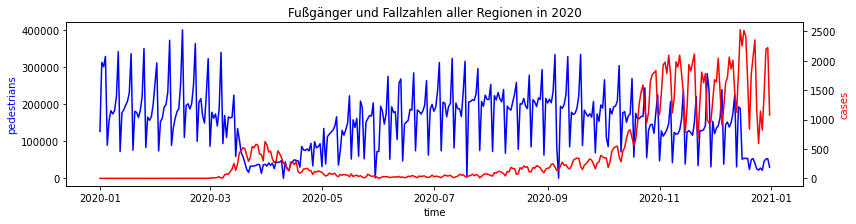

366
366
366


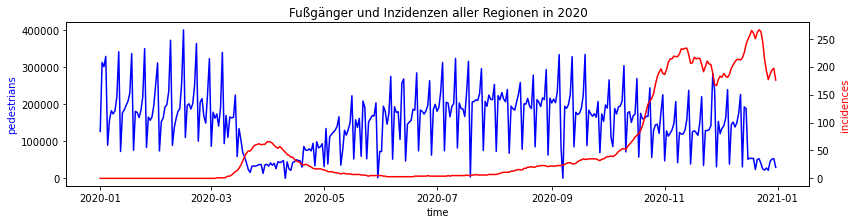

52
52
52


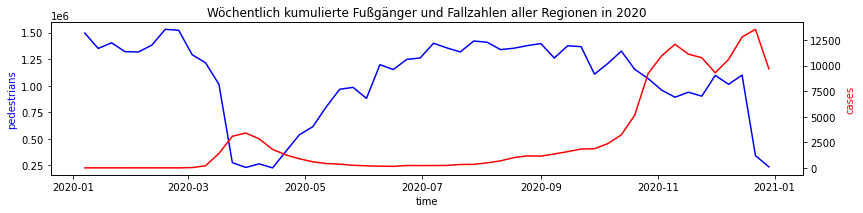

52
52
52


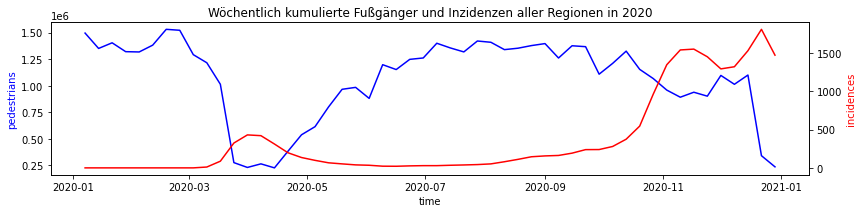

In [20]:
plot(dic_cases,"cases","Fußgänger und Fallzahlen aller Regionen in 2020")
plot(dic_incs,"incidences","Fußgänger und Inzidenzen aller Regionen in 2020")
weekly_cases = per_week(dic_cases)
weekly_incs = per_week(dic_incs)
plot(weekly_cases,"cases","Wöchentlich kumulierte Fußgänger und Fallzahlen aller Regionen in 2020")
plot(weekly_incs,"incidences","Wöchentlich kumulierte Fußgänger und Inzidenzen aller Regionen in 2020")

## Analyse 2.2: Betrachtung spezifischer Zeiträume

### Vorbereitung der Daten

In [21]:
region = "München"
dic_cases = ped_case_dic(region)
dic_incs = to_incidences(dic_cases,region)

In [22]:
peds = [p for p,c in dic_cases.values()]
cases = [c for p,c in dic_cases.values()]
incs = [i for p,i in dic_incs.values()]

### Grundlegende Funktionen zur Betrachtung von spezifischen Zeiträumen

Im Folgenden geht es um die Betrachtung von Fußgängerzahlen und Coronainzidenzen während spezifischen Zeiträumen im Jahr 2020. Dazu zählen Lockdowns, Ferienzeiten oder Feste wie Fastnacht. 
Dazu werden drei Funktionen definiert:

1. Die Funktionen calcDay(date) nimmt ein Datum im Format "dd-mm-yyyy" entgegen und gibt zurück, der wie vielte Tag des Jahres es ist. Dadurch kann man die relevanten Tage im Array ausmachen und für die Zeiträume zwischen Startdatum und Enddatum Visualisierungen und Analysen durchführen.


2. Die Funktion calcCor(startdate, enddate) nimmt ein Startdatum und Enddatum entgegen und berechnet mithilfe der Methode corrcoef(), ob die Fußgängeranzahl und die Coronainzidenzen in dem gewählten Zeitraum korrelieren. Das Ergebnis ist eine Zahl zwischen -1 und 1. Bei einer Zahl Nahe 0 korrelieren die Daten nicht, bei -1 handelt es sich um eine negative Korrelation und bei einem Ergebnis gegen 1 handelt es sich um eine positive Korrelation.


3. Die letzte Funktion plottimeframe(start, end) erstellt einen Graphen mit den Fußgänger- und Coronadaten für den ausgewählten Zeitraum. Auf der x-Achse befindet sich die Zeit. Auf der y-Achse befinden sich die Fußgängeranzahl (blau) und die Coronainzidenzen (rot)

In [23]:
from datetime import datetime

def calcDay(date):
    adate = datetime.strptime(date,"%d-%m-%Y")
    adate = adate.timetuple().tm_yday-1
    return adate

In [24]:
def calcCor(startdate, enddate):
    return np.corrcoef(peds[startdate:enddate+1], incs[startdate:enddate+1])

In [25]:
import matplotlib.pyplot as plt  

def plottimeframe(start, end):
    x = list(dic_cases.keys())

    x = x[start:end+1]

    y1 = list(peds[start:end+1])
    y2 = list(cases[start:end+1])
    y3 = list(incs[start:end+1])

    fig, ax1 = plt.subplots(figsize=(12, 3))

    ax1.set_xlabel('time')
    ax1.set_ylabel('pedestrians', color='b')
    ax1.plot_date(x, y1, linestyle='-', color='b')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('incidences', color='r')
    ax2.plot_date(x, y3, linestyle='-', color='r')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

### Betrachtung: 1. Lockdown März

Im Folgenden wird der erste Lockdown betrachtet. Am 27. Januar wurde der erste Coronafall in Deutschland gemeldet. Am 22. März wurde der erste Lockdown einberufen. Die Betrachtung beginnt am 01. März und endet am 1. Mai. Eine frühere Betrachtung würde keine bedeutenden Ergebnisse liefern, da zu dem Zeitpunkt kaum Fälle aufgetreten sind.
Der erste Schritt ist das Errechnen des Zeitraums mithilfe der calcDay Funktion und die Darstellung mithilfe der Bibliothek matplotlib.

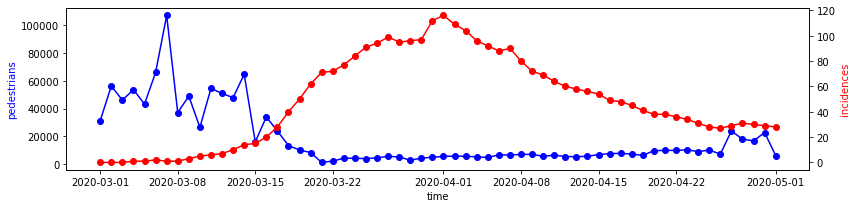

In [26]:
startdate = calcDay("01-03-2020")
enddate = calcDay("01-05-2020")
plottimeframe(startdate, enddate)

In [27]:
test = calcCor(startdate, enddate)
print(test)

[[ 1.         -0.72486187]
 [-0.72486187  1.        ]]


In [28]:
startdate = calcDay("08-03-2020")
enddate = calcDay("01-04-2020")
test = calcCor(startdate, enddate)
print(test)

[[ 1.         -0.83998944]
 [-0.83998944  1.        ]]


In [29]:
startdate = calcDay("01-04-2020")
enddate = calcDay("01-05-2020")
test = calcCor(startdate, enddate)
print(test)

[[ 1.         -0.55440639]
 [-0.55440639  1.        ]]


#### Ergebnis

Anhand der Korrelationsfunktion ist zu erkennen, dass die beiden Werte Fußgängeranzahl und Corona-Inzidenz negativ korrelieren. Daraus und anhand des obigen Graphen ist abzuleiten, dass die Fußgäger bei höherer Inzidenz wenig unterwegs waren.  

### Betrachtung: 2. Lockdown Dezember

Hier wird der zweite Lockdown betrachtet. Am 16. Dezember wurde ein starker Lockdown einberufen. Die Betrachtung beginnt am 30. November und endet am 31. Dezember. 
Der erste Schritt ist wieder das Errechnen des Zeitraums mithilfe der calcDay Funktion und die Darstellung mithilfe der Bibliothek matplotlib.

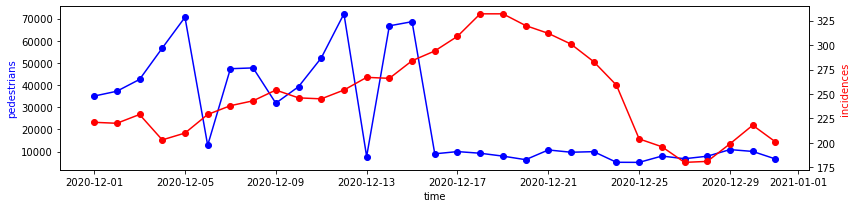

In [30]:
startdate = calcDay("01-12-2020")
enddate = calcDay("31-12-2020")
plottimeframe(startdate, enddate)

In [31]:
test = calcCor(startdate, enddate)
print(test)

[[ 1.         -0.13163236]
 [-0.13163236  1.        ]]


#### Ergebnis

Anhand der Korrelationsfunktion ist zu erkennen, dass die beiden Werte Fußgängeranzahl und Corona-Inzidenz im Dezember negativ korrelieren. Anhand des Graphen ist klar zu erkennen, dass die Fußgängerzahl ab dem Lockdown am 16. Dezember drastisch gesunken ist. Mit ein wenig Verzögerug ist die Inzidenz allerdings auch gesunken und die Fußgängerzahl niedrig geblieben.

### Betrachtung: Sommerferien

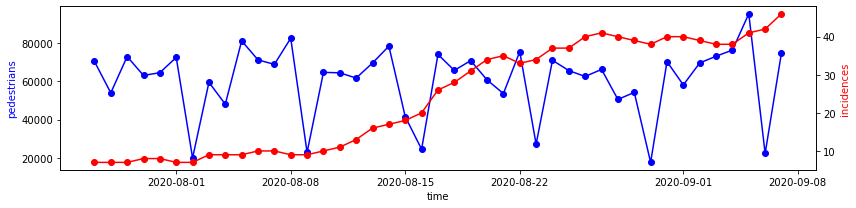

In [32]:
startdate = calcDay("27-07-2020")
enddate = calcDay("07-09-2020")
plottimeframe(startdate, enddate)

In [33]:
test = calcCor(startdate, enddate)
print(test)

[[1.         0.01000753]
 [0.01000753 1.        ]]


#### Ergebnis

Anhand der Korrelationsfunktion ist zu erkennen, dass die beiden Werte Fußgängeranzahl und Corona-Inzidenz kaum korrelieren. Die Inzidenzen steigen stark an während die Anzahl der Fußgänger einen recht konstanten Zyklus aufweist.   

### Betrachtung: Black Friday

Der Black Friday ist ein besonderer Einkaufstag an dem viele Geschäfte besonders hohe Rabatte und Sonderangebote bieten. Dieser fand im Jahr 2020 am 27. November statt. Dabei stellt sich die Frage, ob eine Besonderheit zu erkennen ist.
Dazu wurde das letzte Quartal beobachtet und dabei der Hochpunkt für die Fußgängerdaten ermittelt. Das Datum an dem die meisten Fußgänger erkannt wurden ist in dem Graphen mit einer grünen Senkrechten markiert.

88571
331


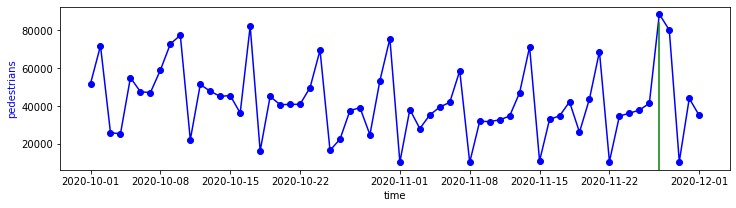

In [34]:
x = list(dic_cases.keys())
alldates = x

start = calcDay("01-10-2020")
end = calcDay("01-12-2020")
        
x = x[start:end+1]

weekend = []
for y in x:
    if(y.weekday() == 6):
        weekend.append(y)

y1 = list(peds[start:end+1])

maxped = max(peds[start:end+1])

for z in range(start,end):
    if(peds[z] == maxped):
        print(peds[z])
        maxped = z
        
fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.set_xlabel('time')
ax1.set_ylabel('pedestrians', color='b')
ax1.plot_date(x, y1, linestyle='-', color='b')

ax1.axvline(alldates[maxped], ymin=0, ymax=0.9, color="g")

print(maxped)
plt.show()

#### Ergebnis

Es ist zu erkennen, dass tatsächlich am 27. November die höchste Anzahl an Fußgängern über das vierte Quartal festgestellt wurde. Das zeigt, dass hohe Ausschläge an Tagen mit besonderen Eigenschaften wie Feiertagen oder speziellen Anreizen auftreten. Diese Besonderheit sollte man bei Analysen mit einbeziehen.

### Betrachtung: Wochenende 

Hier wird beobachtet, ob sich Unterschiede zwischen Wochentagen und dem Wochenende feststellen lassen, wenn man nur die Fußgänger betrachtet Dazu wurde beispielhaft ein Dreimonatszeitraum betrachtet und die Sonntage wurden im Graphen hervorgehoben.

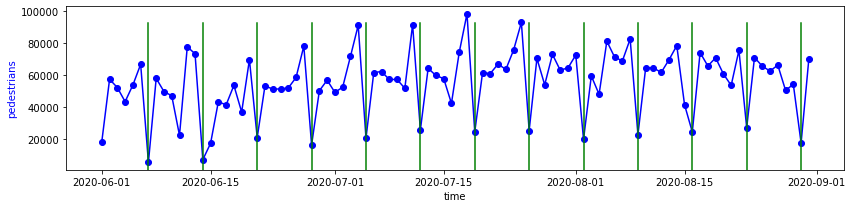

In [35]:
x = list(dic_cases.keys())

start = calcDay("01-06-2020")
end = calcDay("01-09-2020")
        
x = x[start: end]

weekend = []
for y in x:
    if(y.weekday() == 6):
        weekend.append(y)

y1 = list(peds[start:end])
y2 = list(cases[start:end])
y3 = list(incs[start:end])

fig, ax1 = plt.subplots(figsize=(12, 3))

ax1.set_xlabel('time')
ax1.set_ylabel('pedestrians', color='b')
ax1.plot_date(x, y1, linestyle='-', color='b')
for z in weekend:
    ax1.axvline(z, ymin=0, ymax=0.9, color="g")
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Ergebnis

Es lässt sich feststellen, dass die Fußgängeranzahl sonntags deutlich geringer ist als an anderen Tagen. Diese Besonderheit könnte nun für weitere Analysen genutzt werden.

# Analyse 3: Vergleich der Einflüsse von Wetter und Corona-Daten